In [220]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC  
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_rows", 100)

In [221]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [222]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)
i = 1
data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [223]:
# Sanity check to see if control SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "1"].value_counts()

rs2222162  PHENOTYPE
1          1            22
0          1            17
2          1             6
dtype: int64

In [224]:
# Sanity check to see if cases SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "0"].value_counts()

rs2222162  PHENOTYPE
2          0            22
1          0            19
0          0             3
dtype: int64

In [225]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
# dfAlleles = df.loc[:, "rs11684739":"rs6757306"] 500
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [226]:
# Fixing Phenotype values

df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [227]:
# Re-encoding SNP of interest to generate stronger signal

#df.loc[df.PHENOTYPE == "case", ["rs2222162"]] = "2"
#df.loc[df.PHENOTYPE == "control", ["rs2222162"]] = "0"

In [228]:
# Testing to see if amplifying singal increases accuracy

df.insert(df.columns.get_loc("rs2222162"), "rs222216_1", df["rs2222162"])
df.insert(df.columns.get_loc("rs2222162"), "rs222216_2", df["rs2222162"])
df.insert(df.columns.get_loc("rs2222162"), "rs222216_3", df["rs2222162"])
#df.insert(df.columns.get_loc("rs2222162"), "rs222216_4", df["rs2222162"])

In [229]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [230]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [231]:
# Converting columns to be numberical
idf = idf.apply(pd.to_numeric)

In [232]:
# Getting index of SNP of interest
idfT = idf.T
position = idfT[0].index.get_loc("rs2222162")

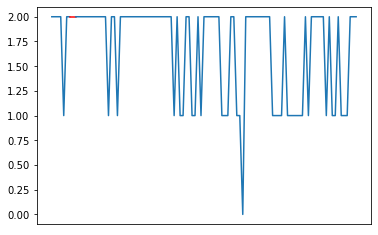

In [233]:
# Visualising entry 0 - control

position = idfT[0].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[0][0:position-1], color="tab:blue")
plt.plot(idfT[0][position-2:position+1], color="red")
plt.plot(idfT[0][position:],color="tab:blue")

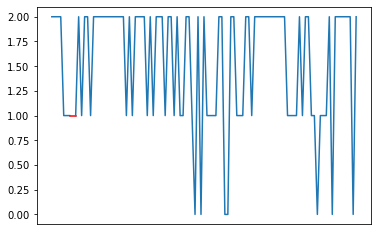

In [234]:
# Visualising entry 1 - control

position = idfT[1].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[1][0:position-1], color="tab:blue")
plt.plot(idfT[1][position-2:position+1], color="red")
plt.plot(idfT[1][position:],color="tab:blue")

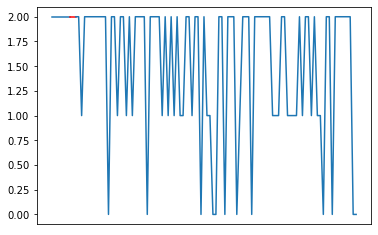

In [235]:
# Visualising entry 2 - case

position = idfT[2].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[2][0:position-1], color="tab:blue")
plt.plot(idfT[2][position-2:position+1], color="red")
plt.plot(idfT[2][position:],color="tab:blue")

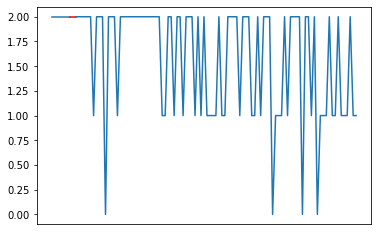

In [236]:
# Visualising entry 10 - case

position = idfT[10].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[10][0:position-1], color="tab:blue")
plt.plot(idfT[10][position-2:position+1], color="red")
plt.plot(idfT[10][position:],color="tab:blue")

In [237]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [238]:
# Finding hyperparameters for RandomForst

# bootstrap = [True, False]
# maxDepth = list(range(10,110,10))
# maxFeatures = ["auto", "sqrt"]
# minSamplesLeaf = [1,2,3,4]
# minSamplesSplit = [2,3,5]
# nEstimators = list(range(100,1100,100))

# hyperparameters = dict(bootstrap=bootstrap, max_depth=maxDepth, max_features=maxFeatures, min_samples_leaf=minSamplesLeaf,
#                       min_samples_split=minSamplesSplit, n_estimators=nEstimators)

# rfd = RandomForestClassifier()

# clf = GridSearchCV(rfd, hyperparameters, cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best bootstrap:', bestModel.best_estimator_.get_params()['bootstrap'])
# print('Best max_depth:', bestModel.best_estimator_.get_params()['max_depth'])
# print('Best max_features:', bestModel.best_estimator_.get_params()['max_features'])
# print('Best min_samples_leaf:', bestModel.best_estimator_.get_params()['min_samples_leaf'])
# print('Best min_samples_split:', bestModel.best_estimator_.get_params()['min_samples_split'])
# print('Best n_estimators:', bestModel.best_estimator_.get_params()['n_estimators'])

In [239]:
# Classifying GWAS data using decision tree and printing results

rfc = RandomForestClassifier(bootstrap=True, max_depth=100, max_features="sqrt", 
                             min_samples_leaf=4, min_samples_split=2, n_estimators=100)
rfc.fit(xTrain, yTrain)
yPredicted = rfc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = rfc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))
print(classification_report(yTest, yPredicted))

Training accuracy score: 0.9245283018867925
Testing accuracy score: 0.5833333333333334
[[ 9 12]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.75      0.43      0.55        21
     control       0.50      0.80      0.62        15

    accuracy                           0.58        36
   macro avg       0.62      0.61      0.58        36
weighted avg       0.65      0.58      0.57        36



<BarContainer object of 10 artists>

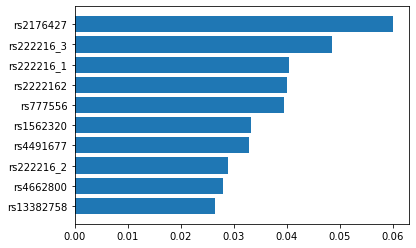

In [240]:
# Plotting features that random forest classifier found important

rf =  pd.DataFrame({"featrue": idf.columns, "importance":rfc.feature_importances_})
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(idf.columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [241]:
# Finding hyperparameters for KNN


# leafSize = list(range(1,30))
# neighbours = list(range(1,30))
# p = [1,2]
# hyperparameters = dict(leaf_size=leafSize, n_neighbors=neighbours, p=p)

# knn = KNeighborsClassifier() 

# clf = GridSearchCV(knn, hyperparameters, cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best leaf_size:', bestModel.best_estimator_.get_params()['leaf_size'])
# print('Best p:', bestModel.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', bestModel.best_estimator_.get_params()['n_neighbors'])

In [242]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier(leaf_size=1, n_neighbors=22,p=2 ) 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.660377358490566
Testing accuracy score: 0.7222222222222222
[[17  4]
 [ 6  9]]


In [243]:
# Finding hyperparameters for KNN

# C = [0.1,1, 10, 100]
# gamma = [1,0.1,0.01,0.001]
# kernel = ['rbf', 'poly', 'sigmoid']
# hyperparameters = dict(C=C,gamma=gamma,kernel=kernel)

# SVM = SVC()

# clf = GridSearchCV(SVM, hyperparameters, refit=True,cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best C:', bestModel.best_estimator_.get_params()['C'])
# print('Best gamma:', bestModel.best_estimator_.get_params()['gamma'])
# print('Best kernel:', bestModel.best_estimator_.get_params()['kernel'])

In [244]:
SVM = SVC(kernel="sigmoid", C=100, gamma=0.001)
SVM.fit(xTrain, yTrain)
yPredicted = SVM.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = SVM.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.8867924528301887
Testing accuracy score: 0.5833333333333334
[[11 10]
 [ 5 10]]


In [245]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [246]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, y_test = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [247]:
# Extracting values from training split

yTrain = yTrain.values
yTest = yTest.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=["index"])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=["index"])

In [248]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [249]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
yPredict = classifier.predict(xTestTransform)
print("Accuracy with Rocket: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

C:\Users\emjcu\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Accuracy with Rocket: 0.611
[[10 11]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.77      0.48      0.59        21
     control       0.52      0.80      0.63        15

    accuracy                           0.61        36
   macro avg       0.65      0.64      0.61        36
weighted avg       0.67      0.61      0.61        36



In [250]:
# Classifying GWAS data using MrSEQL

ms = MrSEQLClassifier(seql_mode="clf")
ms.fit(xTrain, yTrain)
yPredict = ms.predict(xTest)
print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with MrSEQL: 0.694
[[11 10]
 [ 1 14]]
              precision    recall  f1-score   support

        case       0.92      0.52      0.67        21
     control       0.58      0.93      0.72        15

    accuracy                           0.69        36
   macro avg       0.75      0.73      0.69        36
weighted avg       0.78      0.69      0.69        36

